## A simple self-contained notebook that performs **ACET training** on the Two Moons dataset using `tf-eager`

We can clearly see on this 2D example the problem of overconfident
predictions for plain ReLU-networks and the effect of ACET-training. 


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
tf.compat.v1.enable_eager_execution()
from kdg.utils import generate_gaussian_parity, generate_ood_samples, generate_spirals, generate_ellipse
from sklearn.metrics import roc_auc_score

In [3]:
class Model(tf.keras.Model):
  def __init__(self):
    """ A simple two-hidden layer network. """
    super(Model, self).__init__()
    n_in = 2
    # for successful training, the network should be expressive enough
    n_hidden = [10, 10, 10, 10]
    n_classes = 2
    self.w1 = tf.Variable(tf.random.normal([n_in, n_hidden[0]], stddev=tf.sqrt(2/n_in)), name='weight1')
    self.b1 = tf.Variable(tf.zeros(n_hidden[0]), name='bias1')
    self.w2 = tf.Variable(tf.random.normal([n_hidden[0], n_hidden[1]], stddev=tf.sqrt(2/n_hidden[0])), name='weight2')
    self.b2 = tf.Variable(tf.zeros(n_hidden[1]), name='bias2')
    self.w3 = tf.Variable(tf.random.normal([n_hidden[1], n_hidden[2]], stddev=tf.sqrt(2/n_hidden[1])), name='weight3')
    self.b3 = tf.Variable(tf.zeros(n_hidden[2]), name='bias3')
    self.w4 = tf.Variable(tf.random.normal([n_hidden[2], n_hidden[3]], stddev=tf.sqrt(2/n_hidden[2])), name='weight4')
    self.b4 = tf.Variable(tf.zeros(n_hidden[3]), name='bias4')

    self.w5 = tf.Variable(tf.random.normal([n_hidden[3], n_classes], stddev=tf.sqrt(2/n_hidden[3])), name='weight5')
    self.b5 = tf.Variable(tf.zeros(n_classes), name='bias5')
    self.vars = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3, self.w4, self.b4, self.w5, self.b5]
      
  def call(self, x):
    l1 = tf.nn.relu(x @ self.w1 + self.b1)
    l2 = tf.nn.relu(l1 @ self.w2 + self.b2)
    l3 = tf.nn.relu(l2 @ self.w3 + self.b3)
    l4 = tf.nn.relu(l3 @ self.w4 + self.b4)
    l5 = l4 @ self.w5 + self.b5
    return l5


def cross_ent(logits, y):
    losses = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)


def max_conf(logits):
    y = tf.argmax(logits, 1)
    y = tf.one_hot(y, dim)
    losses = -tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
    return tf.reduce_mean(losses)

def gen_adv(x):
    eps = 0.025
    n_iters = 4
    step_size = 0.02

    unif = tf.random.uniform(minval=-eps, maxval=eps, shape=tf.shape(x))
    x_adv = x + unif #tf.clip_by_value(x + unif, 0., 1.)
    
    for i in range(n_iters):
        x_adv = tf.Variable(x_adv)
        with tf.GradientTape() as tape:
            loss = max_conf(model(x_adv))
            grad = tape.gradient(loss, x_adv)
            g = tf.sign(grad)

        # import pdb;pdb.set_trace()
        x_adv_start = x_adv + step_size*g
        #x_adv = tf.clip_by_value(x_adv, 0., 1.)
        delta = x_adv - x_adv_start
        delta = tf.clip_by_value(delta, -eps, eps)
        x_adv = x_adv_start + delta

    return x_adv


In [15]:
dim = 2
# More noise in the moons makes the task harder
X, y = generate_ellipse(10000)
# Rescale and shift the dataset to better fit into zero-one box
#X = (X + 1.6) / 4
#X[:, 0] = X[:, 0] - 0.035
#X[:, 1] = (X[:, 1] - 0.17) * 1.75
y = tf.one_hot(y, depth=2)

model = Model()
# the default learning rate of Adam might not be the best for this dataset
optimizer = tf.optimizers.Adam(3e-4) 

# Training loop
acet = True
if acet:
    n_iter = 3000
else:
    n_iter = 3000

for i in range(1, n_iter+1):
  X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]],minval=-1,maxval=1)
  if acet:
    X_noise = gen_adv(X_noise)
  with tf.GradientTape() as tape:
    logits = model(X)
    logits_noise = model(X_noise)
    loss_main = cross_ent(logits, y)
    loss_acet = acet * max_conf(logits_noise)
    loss = loss_main + loss_acet
  grads = tape.gradient(loss, model.vars)
  optimizer.apply_gradients(zip(grads, model.vars))
  if i % 100  == 0:
    train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
    print("Iter {:03d}: loss_main={:.3f} loss_acet={:.3f} err={:.2%}".format(i, loss_main, loss_acet, train_err))



Iter 100: loss_main=0.617 loss_acet=-0.493 err=41.48%
Iter 200: loss_main=0.529 loss_acet=-0.517 err=7.84%
Iter 300: loss_main=0.499 loss_acet=-0.504 err=4.95%
Iter 400: loss_main=0.474 loss_acet=-0.486 err=4.70%
Iter 500: loss_main=0.453 loss_acet=-0.472 err=4.59%
Iter 600: loss_main=0.433 loss_acet=-0.458 err=4.80%
Iter 700: loss_main=0.414 loss_acet=-0.443 err=4.92%
Iter 800: loss_main=0.393 loss_acet=-0.425 err=5.01%
Iter 900: loss_main=0.372 loss_acet=-0.410 err=5.22%
Iter 1000: loss_main=0.354 loss_acet=-0.396 err=5.24%
Iter 1100: loss_main=0.338 loss_acet=-0.385 err=5.16%
Iter 1200: loss_main=0.324 loss_acet=-0.373 err=5.44%
Iter 1300: loss_main=0.312 loss_acet=-0.368 err=5.89%
Iter 1400: loss_main=0.301 loss_acet=-0.359 err=5.94%
Iter 1500: loss_main=0.292 loss_acet=-0.354 err=5.49%
Iter 1600: loss_main=0.283 loss_acet=-0.346 err=5.55%
Iter 1700: loss_main=0.275 loss_acet=-0.342 err=5.94%
Iter 1800: loss_main=0.269 loss_acet=-0.339 err=5.25%
Iter 1900: loss_main=0.265 loss_acet

In [16]:
def plot(model, plot_min, plot_max, max_prob):
    n_grid = 200
    x_plot = np.linspace(plot_min, plot_max, n_grid)
    y_plot = np.linspace(plot_min, plot_max, n_grid)
    
    points = []
    for xx in x_plot:
        for yy in y_plot:
            points.append((yy, xx))
    points = np.array(points)
    
    logits = model(points)
    probs = tf.nn.softmax(logits).numpy()
    if max_prob:
        z_plot = probs.max(1)
    else:
        z_plot = probs[:, 0]
    z_plot = z_plot.reshape(len(x_plot), len(y_plot)) * 100
    
    ax = plt.gca()
    
    vmax = 100
    vmin = 50 if max_prob else 0
    plt.contourf(x_plot, y_plot, z_plot, levels=np.linspace(50, 100, 50))
    cbar = plt.colorbar(ticks=np.linspace(vmin, vmax, 6))
    
    cbar.ax.set_title('confidence', fontsize=12, pad=12)
    cbar.set_ticklabels(['50%', '60%', '70%', '80%', '90%', '100%'])
    
    y_np = np.array(y)
    X0 = X[y_np.argmax(1)==0]
    X1 = X[y_np.argmax(1)==1]
    #plt.scatter(X0[:, 0], X0[:, 1], s=20, edgecolors='red', facecolor='None',
    #           marker='o', linewidths=0.2)
    #plt.scatter(X1[:, 0], X1[:, 1], s=20, edgecolors='green', facecolor='None',
    #            marker='s', linewidths=0.2)
    plt.xlim([plot_min, plot_max])
    plt.ylim([plot_min, plot_max])
    
    margin = 0.01
    rect = matplotlib.patches.Rectangle((-margin, -margin), 1.0+2*margin, 1.0+2*margin, 
                                        linewidth=1.5, color='white', fill=False)
    ax.add_patch(rect)
    
    plt.gca().set_aspect('equal', adjustable='box')
    #plt.savefig('plots/toy2d_acet={}_{:.1f}_{:.1f}_max_prob={}.pdf'.format(
    #    acet, plot_min, plot_max, max_prob), transparent=True)
    plt.show()


We can see that ACET is effective in the zero-one box, but if we zoom out
we are still able to find overconfident predictions as predicted by Theorem 1.

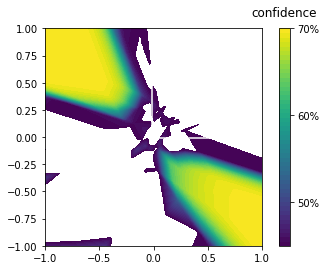

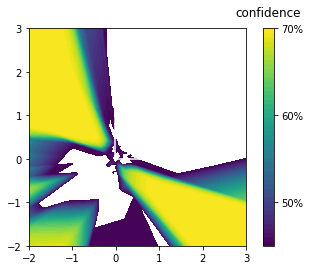

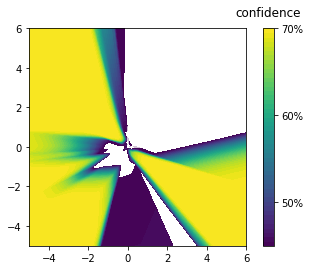

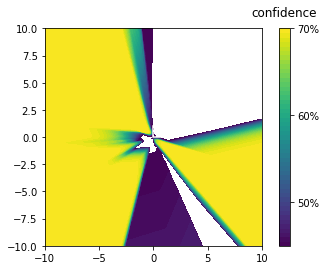

In [17]:
plot(model, -1.0, 1.0, max_prob=False)
plot(model, -2.0, 3.0, max_prob=False)
plot(model, -5.0, 6.0, max_prob=False)
plot(model, -10.0, 10.0, max_prob=False)


### OOD detection metrics

In [4]:

def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [5]:
dim = 2
sample = 10000
reps = 45
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc = []

fpr = []
reps_list = []

for ii in range(reps):
    print('Doing reps ',ii+1)
    X, y = generate_ellipse(sample)
    X_test, y_test = generate_ellipse(n_test)
    X_ood = generate_ood_samples(n_test)

    y = tf.one_hot(y, depth=2)

    model = Model()
    # the default learning rate of Adam might not be the best for this dataset
    optimizer = tf.optimizers.Adam(3e-4) 

    # Training loop
    acet = True
    if acet:
        n_iter = 3000
    else:
        n_iter = 3000

    for i in range(1, n_iter+1):
        X_noise = tf.random.uniform([2*X.shape[0], X.shape[1]],minval=-1,maxval=1)
        if acet:
            X_noise = gen_adv(X_noise)
        with tf.GradientTape() as tape:
            logits = model(X)
            logits_noise = model(X_noise)
            loss_main = cross_ent(logits, y)
            loss_acet = acet * max_conf(logits_noise)
            loss = loss_main + loss_acet
        grads = tape.gradient(loss, model.vars)
        optimizer.apply_gradients(zip(grads, model.vars))
        '''if i % 100  == 0:
            train_err = np.mean(logits.numpy().argmax(1) != y.numpy().argmax(1))
            print("Iter {:03d}: loss_main={:.3f} loss_acet={:.3f} err={:.2%}".format(i, loss_main, loss_acet, train_err))'''
    
    logits = model(X_test)
    probs = tf.nn.softmax(logits).numpy()
    in_conf = np.max(probs, axis=1)

    logits = model(X_ood)
    probs = tf.nn.softmax(logits).numpy()
    out_conf = np.max(probs, axis=1)
    
    conf = np.hstack((in_conf, out_conf))
    roc.append(
        roc_auc_score(true_labels, conf)
    )
    fpr.append(
        fpr_at_95_tpr(in_conf, out_conf)
    )

    reps_list.append(ii)

Doing reps  1
Doing reps  2
Doing reps  3
Doing reps  4
Doing reps  5
Doing reps  6
Doing reps  7
Doing reps  8
Doing reps  9
Doing reps  10
Doing reps  11
Doing reps  12
Doing reps  13
Doing reps  14
Doing reps  15
Doing reps  16
Doing reps  17
Doing reps  18
Doing reps  19
Doing reps  20
Doing reps  21
Doing reps  22
Doing reps  23
Doing reps  24
Doing reps  25
Doing reps  26
Doing reps  27
Doing reps  28
Doing reps  29
Doing reps  30
Doing reps  31
Doing reps  32
Doing reps  33
Doing reps  34
Doing reps  35
Doing reps  36
Doing reps  37
Doing reps  38
Doing reps  39
Doing reps  40
Doing reps  41
Doing reps  42
Doing reps  43
Doing reps  44
Doing reps  45


In [6]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc), np.std(roc)))

AUROC = 0.113 +/- 0.069


In [7]:
# FPR@95
print("FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr), np.std(fpr)))

FPR@95 = 0.747 +/- 0.247
